In [30]:
from __future__ import print_function, division


from pykalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import numpy as np

import shutil

import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
import glob
import random
from PIL import Image
from tqdm import tqdm
import argparse
from bisect import bisect_right, bisect_left
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline

plt.ion()   # interactive mode


In [31]:
#Import csv data from folders

imu_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/imu0/data.csv')
camera_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/data.csv')
vicon_data = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/vicon0/data.csv')

# Drop the first row of the camera

camera_data=camera_data.drop(camera_data.index[[0]])

# re-assign name to columns

vicon_data.columns = ['timestamp','px','py','pz','qw','qx','qy','qz']
camera_data.columns = ['timestamp','filename']
imu_data.columns =['timestamp','wx','wy','wz','ax','ay','az']

# Get the timestamp of the camera and drop the index
camera_timestamps = camera_data['timestamp']
camera_timestamps = camera_timestamps.reset_index(drop=True)


### Interpolate Vicon data to get data at the same timestamp of the camera and IMU
# Vicon data

vicondata = vicon_data.copy() #create a copy

for i in range(len(camera_timestamps)):
    new_row=pd.DataFrame([[camera_timestamps[i],np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]], columns = ['timestamp','px','py','pz','qw','qx','qy','qz'])
    vicondata = pd.concat([vicondata, pd.DataFrame(new_row)], ignore_index=True)
    
vicondata.sort_values(by=['timestamp'],inplace=True, ascending=True)
vicondata = vicondata.reset_index(drop = True)
vicondata = vicondata.interpolate()


def return_idx(timestamps, data):
    "Return the idx of the timestamp of the camera"
    
    idx_sensor = []
    for temp in timestamps:
        idx=int(data[data['timestamp']==temp].index[0])
        idx_sensor.append(idx)
    return idx_sensor

# Create a new vicon dataframe with the same timestamps of the camera

idx_vicon=return_idx(camera_timestamps,vicondata)
new_vicon = vicondata.ix[idx_vicon].reset_index(drop=True)

vicon_timestamp = new_vicon['timestamp'].values

# Create a new IMU dataframe with the same timestamps of the camera

idx_imu = return_idx(camera_timestamps, imu_data)
new_imu = imu_data.ix[idx_imu].reset_index(drop=True)
imu_timestamp = new_imu['timestamp'].values

# Create new dataframe for images and save it

image_data = pd.merge(camera_data, new_vicon, on='timestamp').reset_index(drop=True)
image_data.to_csv(r'/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv',index = None, header=True)

# Let’s read the CSV and get the filenames and labels

file = pd.read_csv('/home/francesca/Desktop/francesca/data/mav0/cam0/image_data.csv')

img_name = file.iloc[:, 1]
labels = file.iloc[:, 2:].as_matrix()



In [79]:
labels

array([[-0.96421648,  0.41556027,  1.44112811, ...,  0.01737689,
         0.02006598,  0.9991999 ],
       [-0.96421855,  0.41552788,  1.44111224, ...,  0.01727664,
         0.02020748,  0.9991968 ],
       [-0.96419539,  0.41558566,  1.4411245 , ...,  0.01740876,
         0.02008069,  0.99920491],
       ...,
       [-3.02587417, -0.62016403,  1.06875461, ...,  0.01077045,
         0.00613887,  0.78427189],
       [-3.0264587 , -0.619776  ,  1.06845905, ...,  0.00435831,
         0.00492559,  0.78497284],
       [-3.02625338, -0.61995997,  1.06861303, ...,  0.0072927 ,
         0.00532574,  0.78509072]])

In [81]:
pos = np.sqrt(labels[:,0]**2 + labels[:,1]**2 + labels[:,2]**2)

speed = pos / (imu_timestamp / 1e9)

vx = np.array(labels[:,0] / (imu_timestamp / 1e9))
vy = np.array(labels[:,1] / (imu_timestamp / 1e9))
vz = labels[:,2] / (imu_timestamp / 1e9)

vel = np.vstack((vx, vy, vz)).T



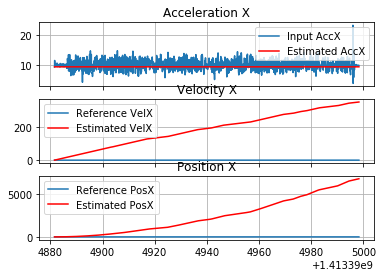

In [101]:


# Data description
#  Time
#  AccX_HP - high precision acceleration signal
#  AccX_LP - low precision acceleration signal
#  RefPosX - real position (ground truth)
#  RefVelX - real velocity (ground truth)

RefPosX = pos
RefVelX = speed
Time = imu_timestamp / 1e9

acc = new_imu.iloc[:,4:].as_matrix()
# AccX_V = np.sqrt(acc[:,0]**2 + acc[:,1]**2 + acc[:,2]**2)
# AccX_Value = np.vstack((Time,AccX_V)).T
AccX_Value = np.sqrt(acc[:,0]**2 + acc[:,1]**2 + acc[:,2]**2)

# AccX_Value = new_imu.iloc[:,4:].as_matrix()
AccX_Variance =  0.0007


# time step
dt = 0.02

# transition_matrix  
F = [[1, dt, 0.5*dt**2], 
     [0,  1,       dt],
     [0,  0,        1]]

# observation_matrix   
H = [0, 0, 1]

# transition_covariance 
Q = [[0.2,    0,      0], 
     [  0,  0.1,      0],
     [  0,    0,  10e-4]]

# observation_covariance 
R = AccX_Variance

# initial_state_mean
X0 = [0,
      0,
      AccX_Value[0]]

# initial_state_covariance
P0 = [[  0,    0,               0], 
      [  0,    0,               0],
      [  0,    0,   AccX_Variance]]

n_timesteps = len(imu_timestamp)
n_dim_state = 3
filtered_state_means = np.zeros((n_timesteps, n_dim_state))
filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))

kf = KalmanFilter(transition_matrices = F, 
                  observation_matrices = H, 
                  transition_covariance = Q, 
                  observation_covariance = R, 
                  initial_state_mean = X0, 
                  initial_state_covariance = P0)

# iterative estimation for each new measurement
for t in range(n_timesteps):
    if t == 0:
        filtered_state_means[t] = X0
        filtered_state_covariances[t] = P0
    else:
        filtered_state_means[t], filtered_state_covariances[t] = (
        kf.filter_update(
            filtered_state_means[t-1],
            filtered_state_covariances[t-1],
            AccX_Value [0]
        )
    )


f, axarr = plt.subplots(3, sharex=True)

axarr[0].plot(Time, AccX_Value, label="Input AccX")
axarr[0].plot(Time, filtered_state_means[:, 2], "r-", label="Estimated AccX")
axarr[0].set_title('Acceleration X')
axarr[0].grid()
axarr[0].legend()
# axarr[0].set_ylim([-4, 4])

axarr[1].plot(Time, RefVelX, label="Reference VelX")
axarr[1].plot(Time, filtered_state_means[:, 1], "r-", label="Estimated VelX")
axarr[1].set_title('Velocity X')
axarr[1].grid()
axarr[1].legend()
# axarr[1].set_ylim([-1, 20])



axarr[2].plot(Time, RefPosX, label="Reference PosX")
axarr[2].plot(Time, filtered_state_means[:, 0], "r-", label="Estimated PosX")
axarr[2].set_title('Position X')
axarr[2].grid()
axarr[2].legend()
# axarr[2].set_ylim([-10, 1000])

plt.show()

In [ ]:
f, axarr = plt.subplots(3, sharex=True)

axarr[0].plot(Time, AccX_Value, label="Input AccX")
axarr[0].plot(Time, filtered_state_means[:, 2], "r-", label="Estimated AccX")
axarr[0].set_title('Acceleration X')
axarr[0].grid()
axarr[0].legend()
# axarr[0].set_ylim([-4, 4])

axarr[1].plot(Time, RefVelX, label="Reference VelX")
axarr[1].plot(Time, filtered_state_means[:, 1], "r-", label="Estimated VelX")
axarr[1].set_title('Velocity X')
axarr[1].grid()
axarr[1].legend()
# axarr[1].set_ylim([-1, 20])



axarr[2].plot(Time, RefPosX, label="Reference PosX")
axarr[2].plot(Time, filtered_state_means[:, 0], "r-", label="Estimated PosX")
axarr[2].set_title('Position X')
axarr[2].grid()
axarr[2].legend()
# axarr[2].set_ylim([-10, 1000])

plt.show()